In [2]:
import numpy as np
import scipy
import proplot as plt
import xarray as xr
from sklearn import linear_model
from multiprocessing import Pool

In [3]:
## Load data 
path = '/home/jupyter-haruki/work/processed/to_s3/'
infname = 'isosph5.denorm_nonorm.CESM2.historical.r1i1p1f1.Input.Exp8.nc'
outfname = 'isosph5.denorm_nonorm.CESM2.historical.r1i1p1f1.Output.nc'
inDS = xr.open_dataset(path + infname)
outDS = xr.open_dataset(path + outfname)

In [5]:
in_variables = ['cres_nonorm','crel_nonorm', 'crelSurf_nonorm', 'netSurfcs_nonorm', 'netTOAcs_nonorm']
out_variables = ['tas_nonorm']

def multilin_coeff(i):
    if i%50==0: print(i)
    xvar = np.array([inDS[var][:,i] for var in in_variables]).T
    yvar = np.array([outDS[var][:,i] for var in out_variables]).T
    clf = linear_model.LinearRegression()
    clf.fit(xvar,yvar)
    return clf.coef_

In [4]:
## calculate multilinear regression for tas_nonorm
ncells = inDS.ncells.shape[0]
proc=80
with Pool(processes=proc) as pool: 
    outdata = pool.map(multilin_coeff, range(ncells))


0
1650
100
1750
1850
300
200
400
600
1950
500
900
2250
700
2450
2150
2050
2550
1400
1100
2350
2300
1600
350
1200
2000
2100
2200
450
800
250
1500
750
2750
1700
1050
1450
1000
50
2850
2650
1900
1350
1250
150
3300
1300
3400
650
2800
3500
3600
2400
2500
850
3800
550
1150
950
3900
2950
3700
4000
3050
3150
1800
3250
1550
3100
3350
2700
3450
4100
4200
3950
3550
2900
3650
3000
4950
3750
41505050

5150
4300
3200
5250
4900
4400
4500
4350
2600
4600
5350
5450
4700
5550
4050
5650
5000
5750
5950
6150
5850
5600
3850
6350
5400
5200
4800
4250
6600
6250
6200
6700
6800
5700
5100
4650
6650
6900
5900
7200
7000
7300
6000
6300
6100
4450
4750
5500
6050
6450
4550
7400
6750
5300
7100
8250
7500
8350
7600
6950
8100
7250
8550
7050
7800
8200
6550
8450
7900
8750
5800
80007150

8650
7550
7700
6400
8850
4850
7350
8300
7650
8050
8950
9250
9150
8600
7850
7950
8400
8500
94509900

8700
9550
7450
10000
7750
6850
9300
10100
9400
9050
9650
8900
10200
9350
9750
8800
6500
9850
9000
10050
9950
9200
10150
8150
9600
9500
9700
910

In [11]:
regressions = {}
for j,var in enumerate(in_variables):
    regressions[var + '_tasreg'] = (["ncells"],np.array(outdata)[:,0,j])

In [12]:
reg_DS = xr.Dataset(data_vars = regressions,
                   coords = {"lat":(["ncells"],inDS.lat.values),
                            "lon":(["ncells"],inDS.lon.values)})

In [13]:
reg_DS.to_netcdf('/home/jupyter-haruki/work/prediction_aibedo/multilin_tas_nonorm_nocressurf.nc')

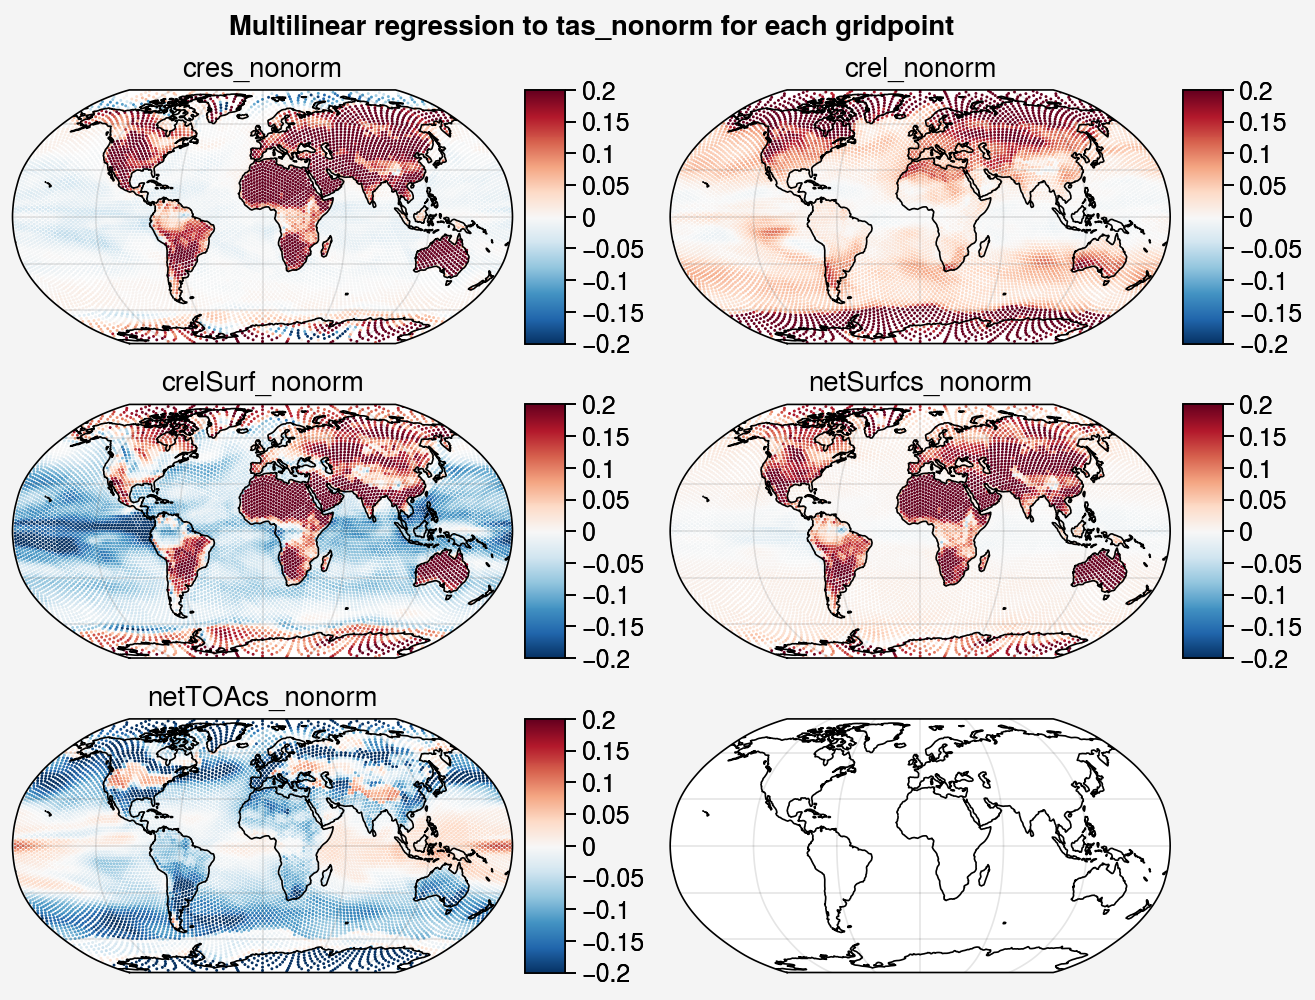

In [18]:
fig,ax = plt.subplots(ncols=2,nrows=3,proj='robin')
fig.format(coast=True,suptitle = 'Multilinear regression to tas_nonorm for each gridpoint')

for i,var in enumerate(in_variables):
    con = ax[i//2,i%2].scatter(inDS.lon,inDS.lat,c=reg_DS[var + '_tasreg'],s=0.2,vmax=0.2,vmin=-0.2)
    ax[i//2,i%2].colorbar(con)
    ax[i//2,i%2].format(title = var)

In [15]:
in_variables = ['cres_nonorm','cresSurf_nonorm', 'crelSurf_nonorm', 'crel_nonorm', 
                'netSurfcs_nonorm', 'netTOAcs_nonorm']
out_variables = ['tas_nonorm']

def multilin_coeff_lag1(i):
    #if i%50==0: print(i)
    xvar = np.array([inDS[var][:-1,i] for var in in_variables]).T
    yvar = np.array([outDS[var][1:,i] for var in out_variables]).T
    clf = linear_model.LinearRegression()
    clf.fit(xvar,yvar)
    return clf.coef_

In [88]:
## calculate multilinear regression for tas_nonorm
ncells = inDS.ncells.shape[0]
proc=80
with Pool(processes=proc) as pool: 
    outdata = pool.map(multilin_coeff_lag1, range(ncells))


In [89]:
regressions = {}
for j,var in enumerate(in_variables):
    regressions[var + '_tasreg'] = (["ncells"],np.array(outdata)[:,0,j])
    
reg_DS = xr.Dataset(data_vars = regressions,
                   coords = {"lat":(["ncells"],inDS.lat.values),
                            "lon":(["ncells"],inDS.lon.values)})
reg_DS.to_netcdf('/home/jupyter-haruki/work/prediction_aibedo/multilin_lag1_reg_tasnonorm.nc')

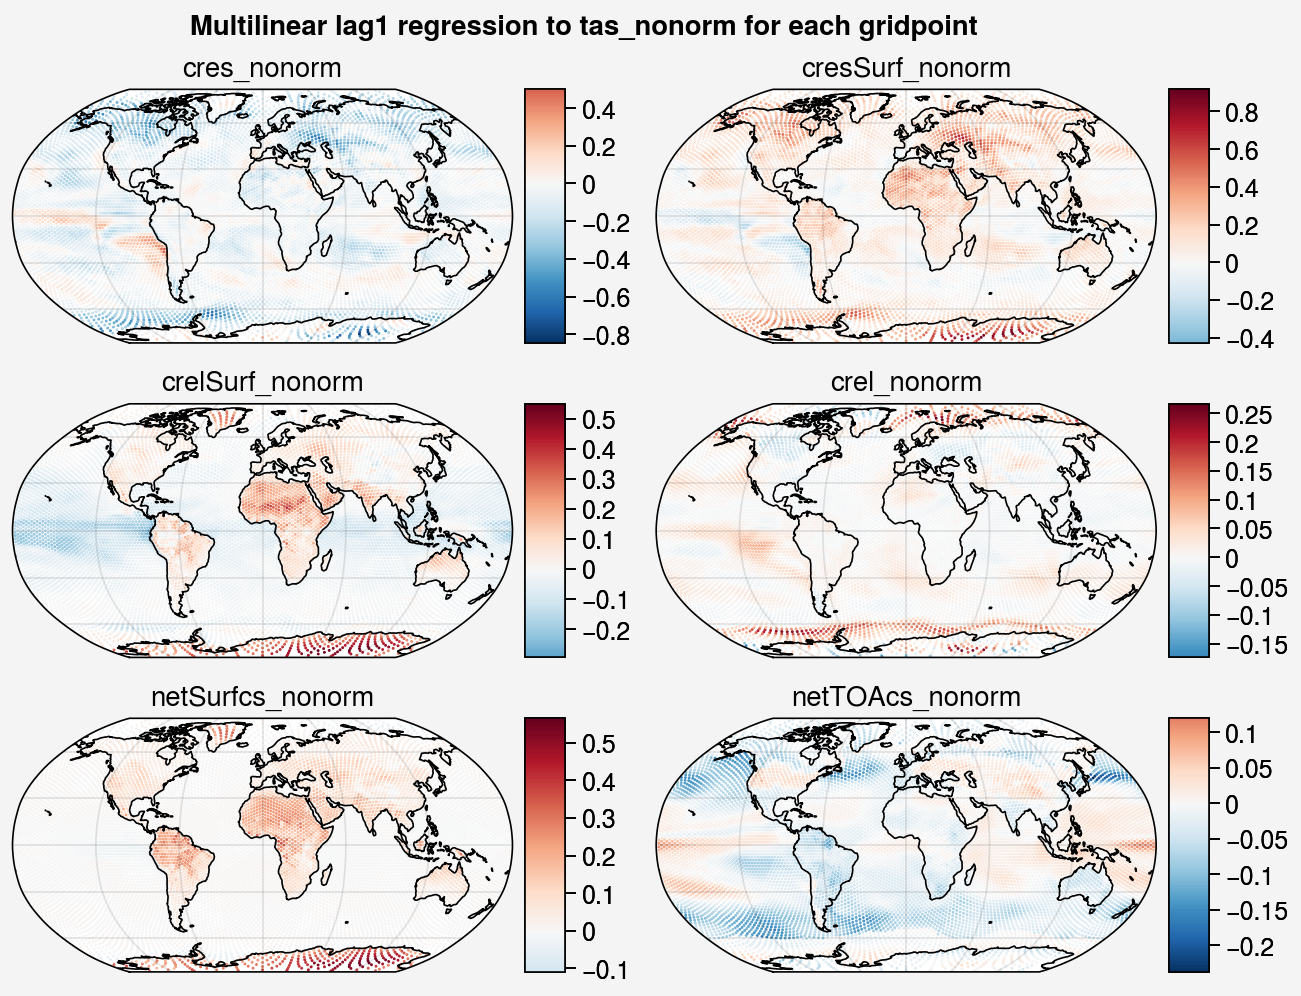

In [90]:
fig,ax = plt.subplots(ncols=2,nrows=3,proj='robin')
fig.format(coast=True,suptitle = 'Multilinear lag1 regression to tas_nonorm for each gridpoint')

for i,var in enumerate(in_variables):
    con = ax[i//2,i%2].scatter(inDS.lon,inDS.lat,c= reg_DS[var + '_tasreg'],s=0.2)
    ax[i//2,i%2].colorbar(con)
    ax[i//2,i%2].format(title = var)

In [6]:

in_variables = ['cres_nonorm','cresSurf_nonorm','crel_nonorm', 'crelSurf_nonorm', 'netSurfcs_nonorm', 'netTOAcs_nonorm']
for outvar in ['tas','pr','psl']:
    out_variables = [f'{outvar}_nonorm']

    def multilin_coeff_lag1(i):
        #if i%50==0: print(i)
        xvar = np.array([inDS[var].values[:-1,i] for var in in_variables]).T
        yvar = np.array([outDS[var].values[1:,i] for var in out_variables]).T
        clf = linear_model.LinearRegression()
        clf.fit(xvar,yvar)
        return clf.coef_    
    ## calculate multilinear regression for tas_nonorm
    ncells = inDS.ncells.shape[0]
    proc=80
    with Pool(processes=proc) as pool: 
        outdata = pool.map(multilin_coeff, range(ncells))
    regressions = {}
    for j,invar in enumerate(in_variables):
        regressions[invar + f'_{outvar}reg'] = (["ncells"],np.array(outdata)[:,0,j])

    reg_DS = xr.Dataset(data_vars = regressions,
                       coords = {"lat":(["ncells"],inDS.lat.values),
                                "lon":(["ncells"],inDS.lon.values)})
    reg_DS.to_netcdf('/home/jupyter-haruki/work/prediction_aibedo/multilin_lag1_{0}_nonorm.nc'.format(outvar))

0
1650
1750
100
1850
1950
400
300
200
500
2050
2450
2250
700
2150
800
900
15001600

600
1100
1800
1900
1000
1700
2350
2600
2000
2550
2400
50
1200
350
950
1300
1150
2650
150
850
2850
650
1450
2300
2950
3300
3400
3500
1350
450
2700
1550
3150
3600
2900
2100
2800
750
3700
3800
2200
2750
1400
3900
3000
4000
3250
1050
2500
4200
3350
3050
1250
3550
4050
4300
4150
4400
4950
3100
4250
3450
3950
5050
3850
250
4100
3750
5150
3200
4450
550
5250
4500
4550
3650
5650
5350
5750
5550
4600
5200
5450
5300
5850
6050
4800
6600
4700
5950
5700
4900
6700
6150
4350
5500
6800
5900
6100
5800
6250
6550
6900
5000
7000
5400
7200
7100
4650
6850
6450
6400
7300
6000
5100
4850
6350
7400
7500
8250
7150
6750
7700
65007600

66508350

7250
6300
8450
5600
8550
7800
8650
7050
8750
8950
8850
9050
4750
6950
8000
7450
9150
7350
6200
7650
8200
8100
8400
7550
9250
8500
8600
9450
7950
9900
8300
9100
7750
9000
9350
10000
10100
9550
8900
10200
8800
9300
7900
9200
8700
9650
8150
9950
10150
9850
9700
9500
10050
9800
9750
9400
8050
960

## Preprocessed variables

In [8]:

in_variables = ['cres_pre','cresSurf_pre','crel_pre', 'crelSurf_pre', 'netSurfcs_pre', 'netTOAcs_pre']
for outvar in ['tas','pr','psl']:
    out_variables = [f'{outvar}_pre']

    def multilin_coeff(i):
        if i%50==0: print(i)
        xvar = np.array([inDS[var][:,i] for var in in_variables]).T
        yvar = np.array([outDS[var][:,i] for var in out_variables]).T
        clf = linear_model.LinearRegression()
        clf.fit(xvar,yvar)
        return clf.coef_
    
    ## calculate multilinear regression for tas_pre
    ncells = inDS.ncells.shape[0]
    proc=80
    with Pool(processes=proc) as pool: 
        outdata = pool.map(multilin_coeff, range(ncells))
    regressions = {}
    for j,invar in enumerate(in_variables):
        regressions[invar + f'_{outvar}reg'] = (["ncells"],np.array(outdata)[:,0,j])

    reg_DS = xr.Dataset(data_vars = regressions,
                       coords = {"lat":(["ncells"],inDS.lat.values),
                                "lon":(["ncells"],inDS.lon.values)})
    reg_DS.to_netcdf('/home/jupyter-haruki/work/prediction_aibedo/multilin_{0}_pre.nc'.format(outvar))

0
1650
1750
100
1850
200
300
1950
2050
400
2150
2250
500
2550
2350
800600

700
2450
900
1300
1000
1100
1200
1500
50
150
450
1600
1400
250
2200
1700
2100
2000
350
1800
1900
1150
550
2500
950
750
650
2400
2300
1550
2600
1250
3300
1050
1450
1350
3400
3500
2650
850
3600
3700
2750
2850
4950
3800
2950
5050
3900
3050
4000
3150
4100
4200
5150
3350
3250
4400
2700
45004300

5250
3450
4800
2800
3550
4900
4700
4600
3650
2900
3750
3000
3850
4050
5350
3950
5000
5450
4250
4450
4150
3100
5550
5100
4350
5650
4550
3200
5200
5750
6600
4650
6700
5850
4750
6800
4850
5300
6900
5400
5500
5950
7000
6050
6150
7100
5600
6350
7200
6250
7300
5700
6450
7400
5800
6550
5900
7500
6650
6750
8250
7600
6850
7050
8350
6100
6200
6000
6950
8450
7900
7700
6400
7800
7150
8100
8000
8550
7250
6300
7350
6500
7450
8650
8750
8200
8850
8400
8300
8950
9900
7950
9050
7550
10000
8500
8600
9150
10100
9250
8050
7650
7750
9350
10200
8700
9450
8800
8900
9650
9550
7850
9750
8150
9850
9100
10050
9000
9950
9200
10150
9400
9300
9500
9600
970

In [7]:
reg_DS

<xarray.Dataset>
Dimensions:                         (ncells: 10242)
Coordinates:
    lat                             (ncells) float64 58.28 -58.28 ... 1.184
    lon                             (ncells) float64 -90.0 -90.0 ... -21.59
Dimensions without coordinates: ncells
Data variables:
    cres_pre_cres_prereg            (ncells) float32 -0.4119 -0.2429 ... 0.2563
    cresSurf_pre_cresSurf_prereg    (ncells) float32 0.5073 -0.0997 ... 0.003663
    crel_pre_crel_prereg            (ncells) float32 -0.2665 -0.5713 ... -0.2159
    crelSurf_pre_crelSurf_prereg    (ncells) float32 0.1541 0.08679 ... 0.3371
    netSurfcs_pre_netSurfcs_prereg  (ncells) float32 -0.1569 0.1988 ... 0.07562
    netTOAcs_pre_netTOAcs_prereg    (ncells) float32 0.04245 ... 0.01914

## EOF covariance

In [153]:
import sklearn.decomposition

In [166]:
def get_svd(data):
    svd = np.linalg.svd(data.values)
    ds = {"singular_vals":(["nt"],svd[1]),
         "PC":(["nt","nt"],svd[0]),
         "EOFs":(["ncells","ncells"],svd[2])}
    reg_DS = xr.Dataset(data_vars = ds,
                   coords = {"lat":(["ncells"],inDS.lat.values),
                            "lon":(["ncells"],inDS.lon.values),
                            "time":(["nt"],inDS.time.values)})
    return reg_DS

In [169]:
in_variables = ['cres_nonorm','cresSurf_nonorm','crel_nonorm', 'crelSurf_nonorm', 'netSurfcs_nonorm', 'netTOAcs_nonorm']
out_variables = ['tas_nonorm','psl_nonorm','pr_nonorm']


In [168]:
inSVD = {var:get_svd(inDS[var]) for var in in_variables}

In [170]:
outSVD = {var:get_svd(outDS[var]) for var in out_variables}

In [171]:
inSVD

{'cres_nonorm': <xarray.Dataset>
 Dimensions:        (nt: 1980, ncells: 10242)
 Coordinates:
     lat            (ncells) float64 58.28 -58.28 58.28 ... -1.184 1.184 1.184
     lon            (ncells) float64 -90.0 -90.0 90.0 ... -21.59 -25.66 -21.59
     time           (nt) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
 Dimensions without coordinates: nt, ncells
 Data variables:
     singular_vals  (nt) float32 1.555e+04 1.02e+04 ... 4.739e-05 4.554e-05
     PC             (nt, nt) float32 0.01052 -0.01221 0.017 ... 0.083 0.1492
     EOFs           (ncells, ncells) float32 -0.0007375 0.0003566 ... 0.7601,
 'cresSurf_nonorm': <xarray.Dataset>
 Dimensions:        (nt: 1980, ncells: 10242)
 Coordinates:
     lat            (ncells) float64 58.28 -58.28 58.28 ... -1.184 1.184 1.184
     lon            (ncells) float64 -90.0 -90.0 90.0 ... -21.59 -25.66 -21.59
     time           (nt) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
 Dimensions without coordinates: nt, ncells
 Data 

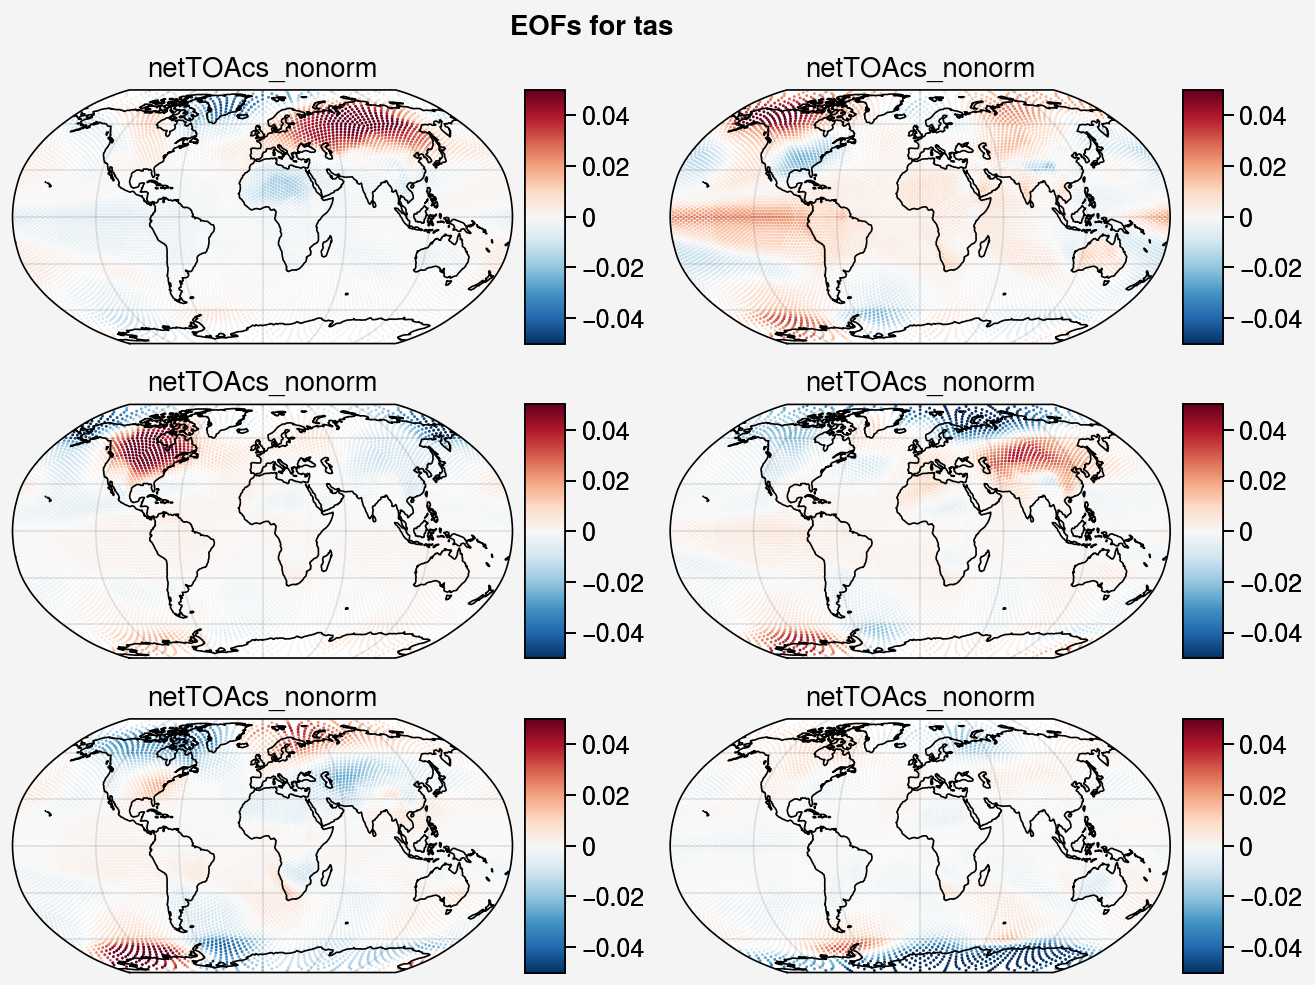

In [148]:
fig,ax = plt.subplots(ncols=2,nrows=3,proj='robin')
fig.format(coast=True,suptitle = 'EOFs for tas')

for i in range(6):
    con = ax[i].scatter(inDS.lon,inDS.lat,c=svd_tas[2][i],s=0.2,vmax=0.05,vmin=-0.05)
    ax[i].colorbar(con)
    ax[i].format(title = var)

## Regional mean regression

In [6]:
lats = [-30,0]
lons = [-110,-70]
lat0,lat1 = lats
lon0,lon1 = lons
in_variables = ['cres_nonorm','cresSurf_nonorm','crel_nonorm', 'crelSurf_nonorm', 'netSurfcs_nonorm', 'netTOAcs_nonorm']
out_variables = ['tas_nonorm','psl_nonorm','pr_nonorm']

regmean = {}
for var in in_variables:
    regmean[var] = inDS[var].where((inDS.lat > lat0) & (inDS.lat < lat1) & (inDS.lon > lon0) & (inDS.lon < lon1)).mean(('ncells'))
for var in out_variables:
    regmean[var] = outDS[var].where((inDS.lat > lat0) & (inDS.lat < lat1) & (inDS.lon > lon0) & (inDS.lon < lon1)).mean(('ncells'))


In [12]:
xvar = np.array([regmean['cres_nonorm'],regmean['crelSurf_nonorm']]).T
yvar = np.array([regmean['tas_nonorm'],]).T
clf = linear_model.LinearRegression()
clf.fit(xvar,yvar)
clf.coef_

array([-0.01727641, -0.13942496], dtype=float32)

In [35]:
tas_anom = []
i= 0 
arr_cres = np.arange(-30,31,2)
arr_crel = np.arange(-20,21,2)

for cres in arr_cres:
    tas_anom.append([])
    for crelSurf in arr_crel:
        tas_anom[i].append(clf.coef_[0][0]*cres + clf.coef_[0][1]*crelSurf)
    i += 1
crels,cress = np.meshgrid(arr_crel,arr_cres)
tas_anom = np.array(tas_anom)

In [36]:
cress.shape

(31, 21)

0
1
2
4


Text(0.5, 0.98, 'CESM2 SEP tas_nonorm relationship to cres and crelSurf\nandMultilinear regression in heatmap')

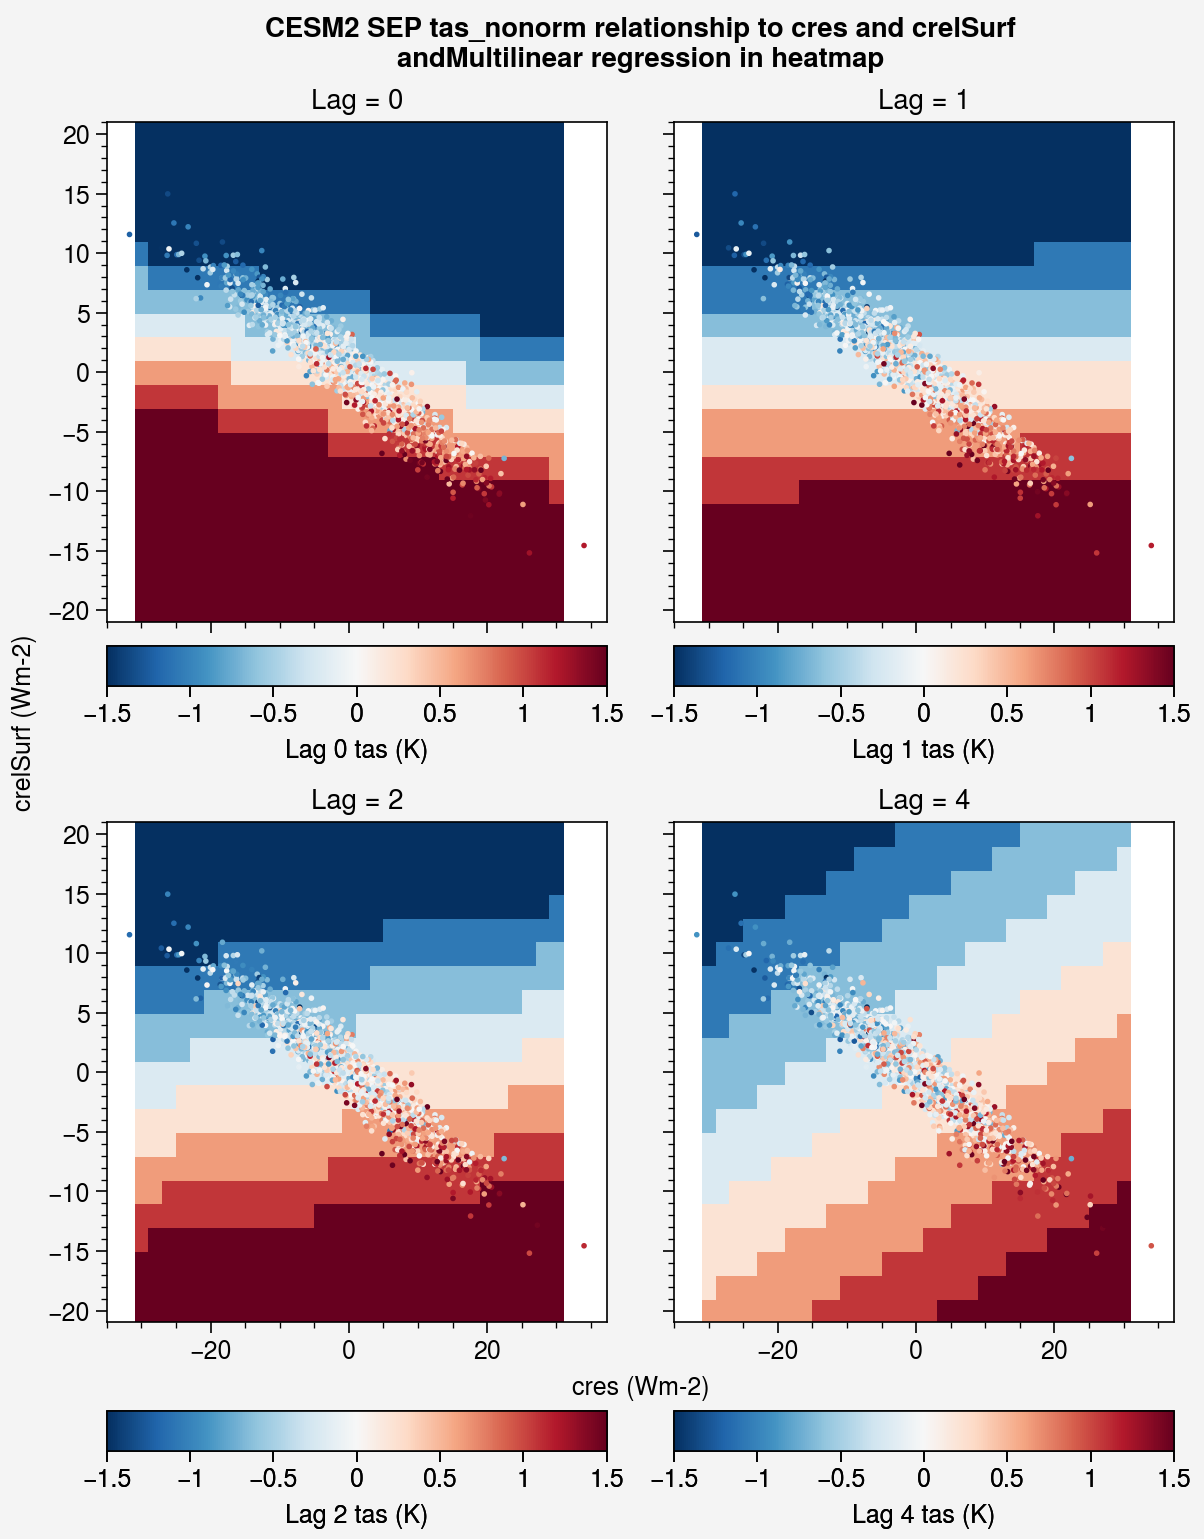

In [53]:
fig,axes = plt.subplots(ncols=2,nrows=2)

for j,lag in enumerate([0,1,2,4]):
    print(lag)
    if lag > 0:
        xvar = np.array([regmean['cres_nonorm'].values[:-lag],regmean['crelSurf_nonorm'].values[:-lag]]).T
        yvar = np.array([regmean['tas_nonorm'].values[lag:]]).T
        clf = linear_model.LinearRegression()
        clf.fit(xvar,yvar)
        clf.coef_
    else:
        xvar = np.array([regmean['cres_nonorm'].values[:],regmean['crelSurf_nonorm'].values[:]]).T
        yvar = np.array([regmean['tas_nonorm'].values[:]]).T
        clf = linear_model.LinearRegression()
        clf.fit(xvar,yvar)
        clf.coef_
        
    tas_anom = []
    i= 0 
    arr_cres = np.arange(-30,31,2)
    arr_crel = np.arange(-20,21,2)

    for cres in arr_cres:
        tas_anom.append([])
        for crelSurf in arr_crel:
            tas_anom[i].append(clf.coef_[0][0]*cres + clf.coef_[0][1]*crelSurf)
        i += 1
    crels,cress = np.meshgrid(arr_crel,arr_cres)
    tas_anom = np.array(tas_anom)
    
    ax = axes[j]
    con = ax.pcolormesh(cress,crels,tas_anom,vmax=1.5,vmin=-1.5)
    if lag > 0:
        con = ax.scatter(regmean['cres_nonorm'].values[:-lag],regmean['crelSurf_nonorm'].values[:-lag],s=2,
               color=regmean['tas_nonorm'].values[lag:],vmax=1.5,
               vmin=-1.5)
    else:
        con = ax.scatter(regmean['cres_nonorm'].values[:],regmean['crelSurf_nonorm'].values[:],s=2,
               color=regmean['tas_nonorm'].values[:],vmax=1.5,
               vmin=-1.5)
        
    ax.colorbar(con,loc='b',label='Lag {0} tas (K)'.format(lag))
    ax.set_xlabel('cres (Wm-2)')
    ax.set_ylabel('crelSurf (Wm-2)')
    ax.set_title('Lag = {0}'.format(lag))
fig.suptitle('CESM2 SEP tas_nonorm relationship to cres and crelSurf\nand' + 'Multilinear regression in heatmap')

0
1
2
4


Text(0.5, 0.98, 'CESM2 SEP tas_nonorm relationship to cres and crelSurf\nandMultilinear regression in heatmap (multilin including cresSurf)')

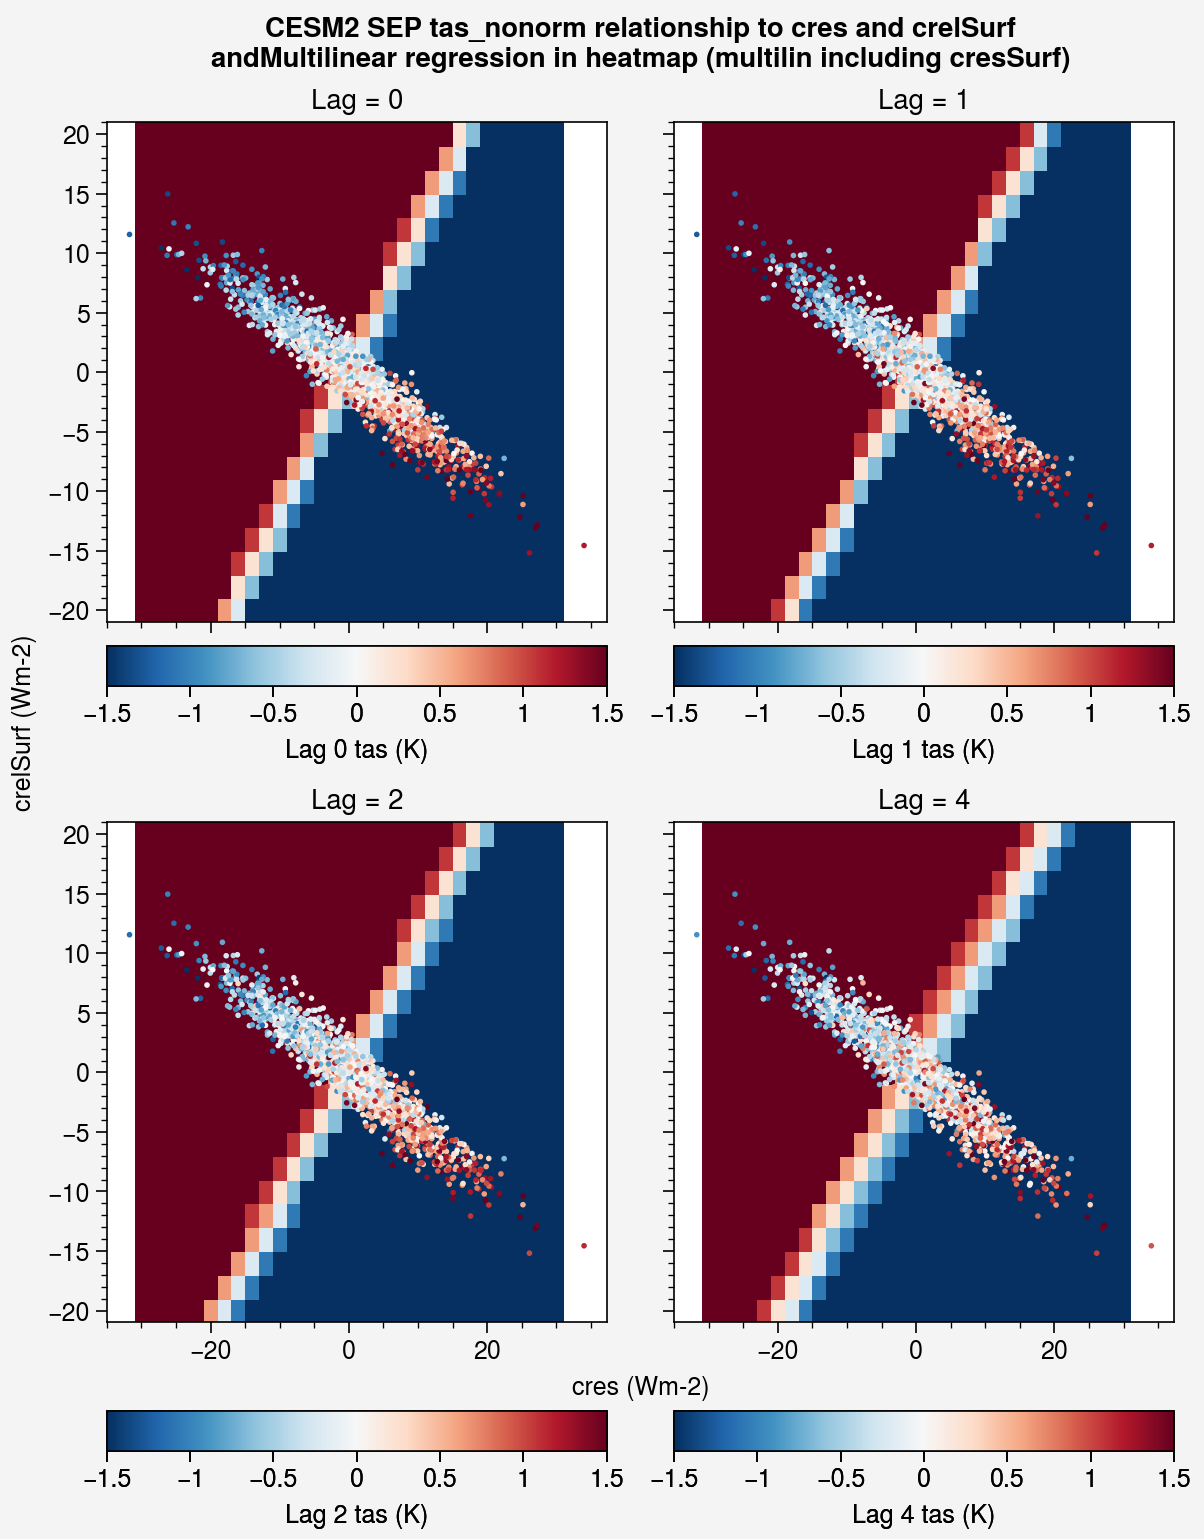

In [54]:
fig,axes = plt.subplots(ncols=2,nrows=2)

for j,lag in enumerate([0,1,2,4]):
    print(lag)
    if lag > 0:
        xvar = np.array([regmean['cres_nonorm'].values[:-lag],regmean['cresSurf_nonorm'].values[:-lag],regmean['crelSurf_nonorm'].values[:-lag]]).T
        yvar = np.array([regmean['tas_nonorm'].values[lag:]]).T
        clf = linear_model.LinearRegression()
        clf.fit(xvar,yvar)
        clf.coef_
    else:
        xvar = np.array([regmean['cres_nonorm'].values[:],regmean['cresSurf_nonorm'].values[:],regmean['crelSurf_nonorm'].values[:]]).T
        yvar = np.array([regmean['tas_nonorm'].values[:]]).T
        clf = linear_model.LinearRegression()
        clf.fit(xvar,yvar)
        clf.coef_
        
    tas_anom = []
    i= 0 
    arr_cres = np.arange(-30,31,2)
    arr_crel = np.arange(-20,21,2)

    for cres in arr_cres:
        tas_anom.append([])
        for crelSurf in arr_crel:
            tas_anom[i].append(clf.coef_[0][0]*cres + clf.coef_[0][1]*crelSurf)
        i += 1
    crels,cress = np.meshgrid(arr_crel,arr_cres)
    tas_anom = np.array(tas_anom)
    
    ax = axes[j]
    con = ax.pcolormesh(cress,crels,tas_anom,vmax=1.5,vmin=-1.5)
    if lag > 0:
        con = ax.scatter(regmean['cres_nonorm'].values[:-lag],regmean['crelSurf_nonorm'].values[:-lag],s=2,
               color=regmean['tas_nonorm'].values[lag:],vmax=1.5,
               vmin=-1.5)
    else:
        con = ax.scatter(regmean['cres_nonorm'].values[:],regmean['crelSurf_nonorm'].values[:],s=2,
               color=regmean['tas_nonorm'].values[:],vmax=1.5,
               vmin=-1.5)
        
    ax.colorbar(con,loc='b',label='Lag {0} tas (K)'.format(lag))
    ax.set_xlabel('cres (Wm-2)')
    ax.set_ylabel('crelSurf (Wm-2)')
    ax.set_title('Lag = {0}'.format(lag))
fig.suptitle('CESM2 SEP tas_nonorm relationship to cres and crelSurf\nand' + 'Multilinear regression in heatmap (multilin including cresSurf)')

0
1
2
4


Text(0.5, 0.98, 'CESM2 SEP tas_nonorm relationship to cresSurf and netSurfcs\nandMultilinear regression in heatmap')

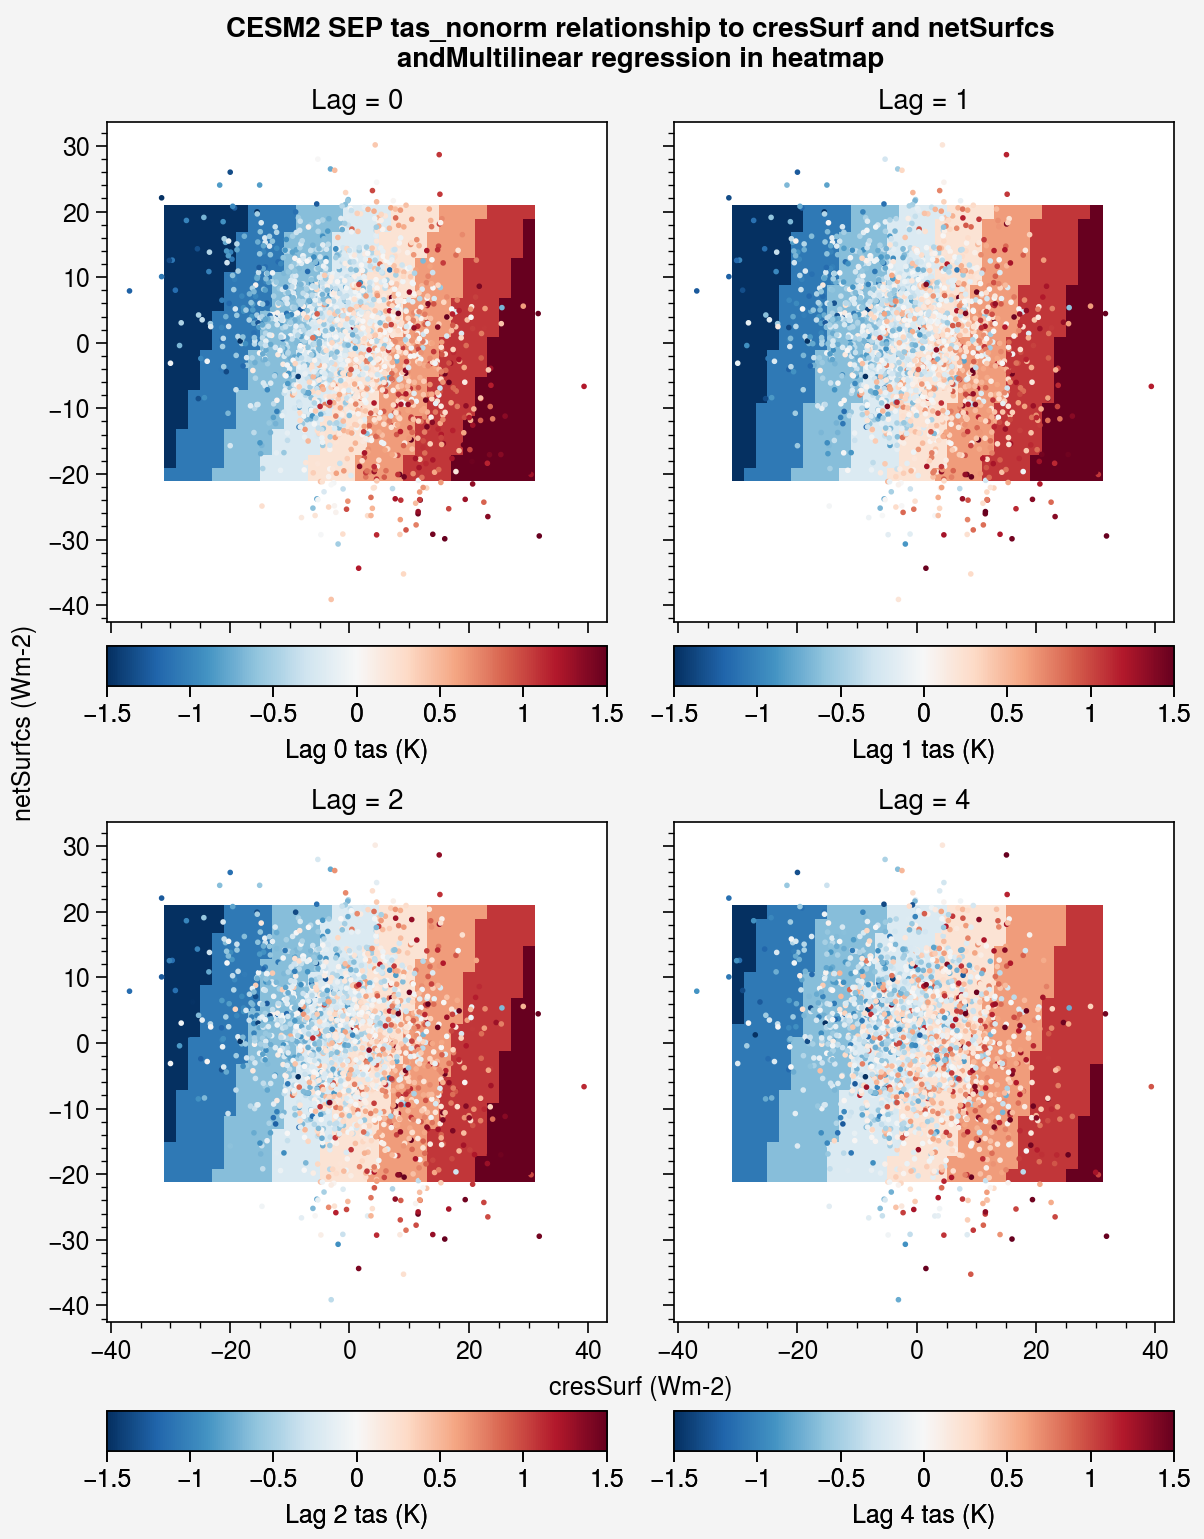

In [58]:
fig,axes = plt.subplots(ncols=2,nrows=2)

for j,lag in enumerate([0,1,2,4]):
    print(lag)
    if lag > 0:
        xvar = np.array([regmean['cresSurf_nonorm'].values[:-lag],regmean['netSurfcs_nonorm'].values[:-lag]]).T
        yvar = np.array([regmean['tas_nonorm'].values[lag:]]).T
        clf = linear_model.LinearRegression()
        clf.fit(xvar,yvar)
        clf.coef_
    else:
        xvar = np.array([regmean['cresSurf_nonorm'].values[:],regmean['netSurfcs_nonorm'].values[:]]).T
        yvar = np.array([regmean['tas_nonorm'].values[:]]).T
        clf = linear_model.LinearRegression()
        clf.fit(xvar,yvar)
        clf.coef_
        
    tas_anom = []
    i= 0 
    arr_cres = np.arange(-30,31,2)
    arr_crel = np.arange(-20,21,2)

    for cres in arr_cres:
        tas_anom.append([])
        for crelSurf in arr_crel:
            tas_anom[i].append(clf.coef_[0][0]*cres + clf.coef_[0][1]*crelSurf)
        i += 1
    crels,cress = np.meshgrid(arr_crel,arr_cres)
    tas_anom = np.array(tas_anom)
    
    ax = axes[j]
    con = ax.pcolormesh(cress,crels,tas_anom,vmax=1.5,vmin=-1.5)
    if lag > 0:
        con = ax.scatter(regmean['cresSurf_nonorm'].values[:-lag],regmean['netSurfcs_nonorm'].values[:-lag],s=2,
               color=regmean['tas_nonorm'].values[lag:],vmax=1.5,
               vmin=-1.5)
    else:
        con = ax.scatter(regmean['cresSurf_nonorm'].values[:],regmean['netSurfcs_nonorm'].values[:],s=2,
               color=regmean['tas_nonorm'].values[:],vmax=1.5,
               vmin=-1.5)
        
    ax.colorbar(con,loc='b',label='Lag {0} tas (K)'.format(lag))
    ax.set_xlabel('cresSurf (Wm-2)')
    ax.set_ylabel('netSurfcs (Wm-2)')
    ax.set_title('Lag = {0}'.format(lag))
fig.suptitle('CESM2 SEP tas_nonorm relationship to cresSurf and netSurfcs\nand' + 

             'Multilinear regression in heatmap')

Text(0.5, 0.98, 'SEP Multilinear regression coefficients')

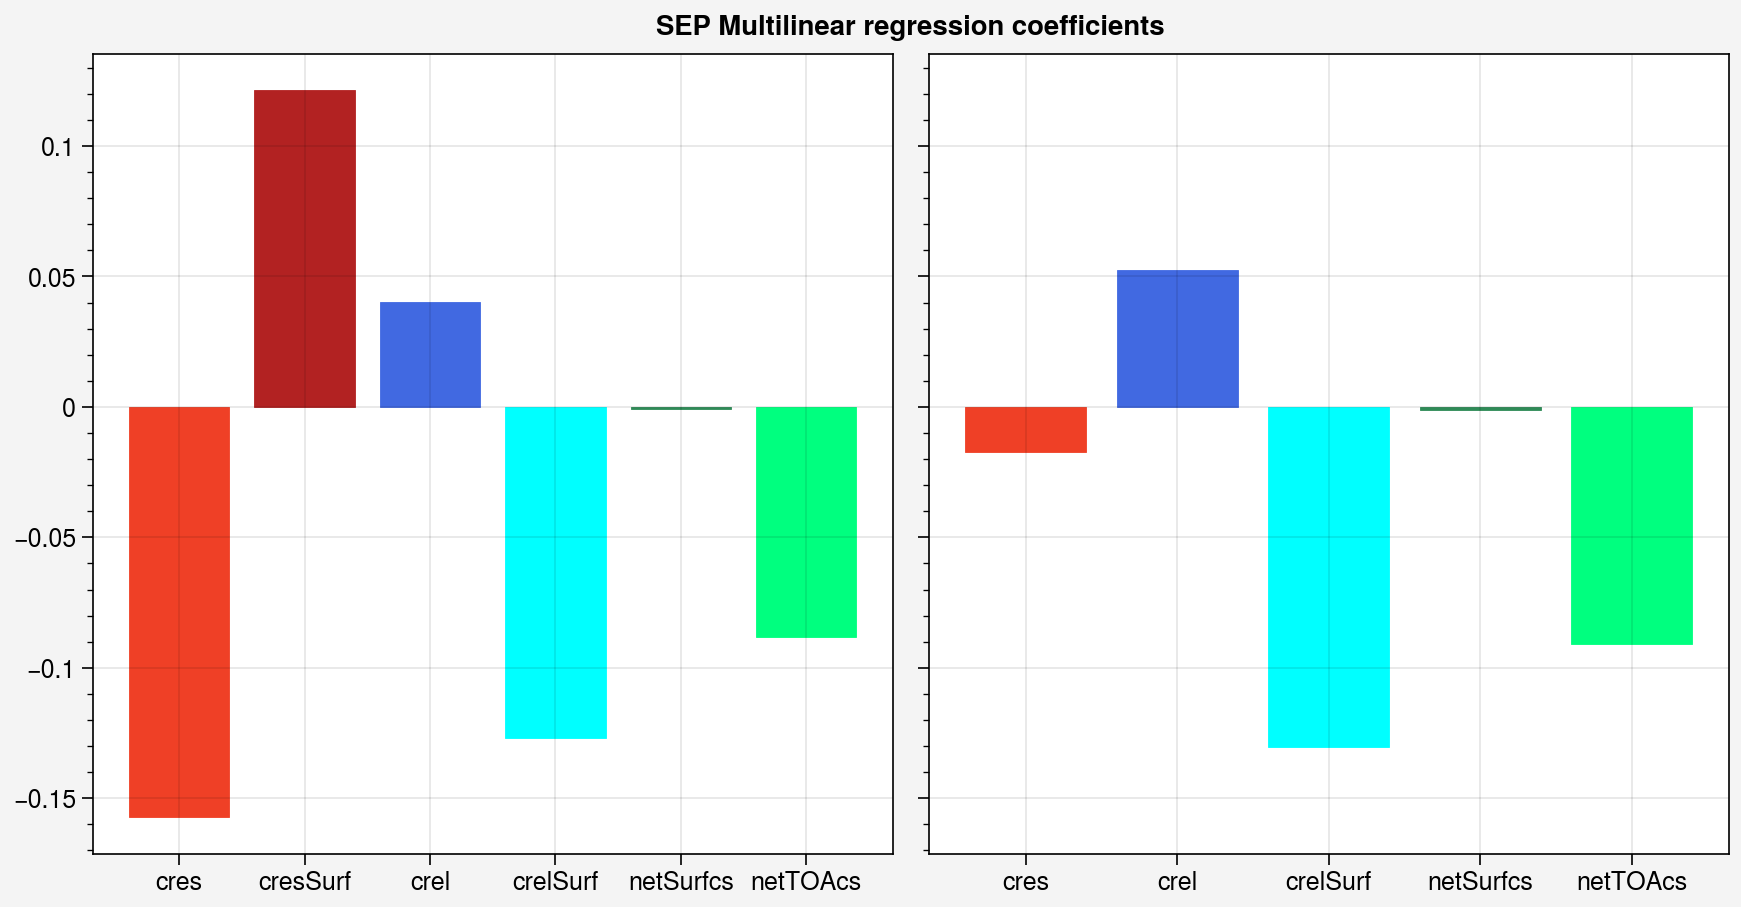

In [78]:
fig,ax = plt.subplots(ncols=2,nrows=1,sharex=False,refwidth=4)

variables = ['cres_nonorm','cresSurf_nonorm','crel_nonorm', 'crelSurf_nonorm', 'netSurfcs_nonorm', 'netTOAcs_nonorm']
xvar = np.array([regmean[var].values[:] for var in variables]).T
yvar = np.array([regmean['tas_nonorm'].values[:]]).T
clf = linear_model.LinearRegression()
clf.fit(xvar,yvar)
clf.coef_

ax[0].bar([var.split('_')[0] for var in variables],clf.coef_[0],
         color = ['tomato','firebrick','royalblue','cyan','seagreen','springgreen'])

variables = ['cres_nonorm', 'crel_nonorm','crelSurf_nonorm', 'netSurfcs_nonorm', 'netTOAcs_nonorm']
xvar = np.array([regmean[var].values[:] for var in variables]).T
yvar = np.array([regmean['tas_nonorm'].values[:]]).T
clf = linear_model.LinearRegression()
clf.fit(xvar,yvar)
clf.coef_

ax[1].bar([var.split('_')[0] for var in variables],clf.coef_[0],
         color = ['tomato','royalblue','cyan','seagreen','springgreen'])
fig.suptitle('SEP Multilinear regression coefficients')

Text(0.5, 0.98, 'SEP Multilinear regression coefficients')

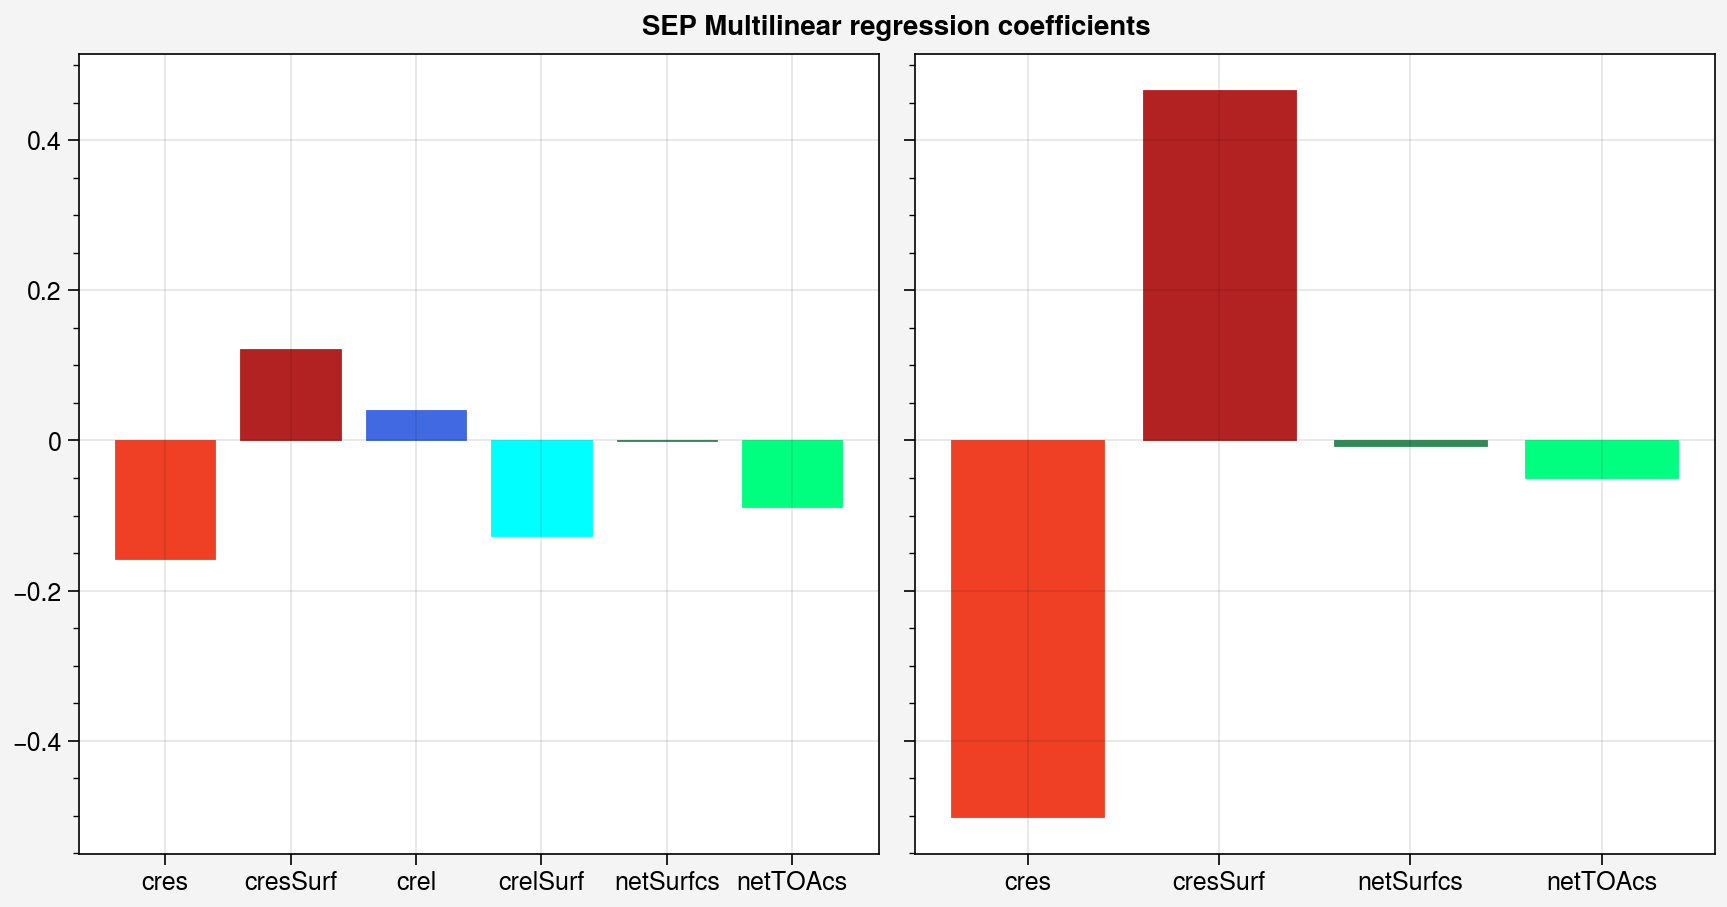

In [80]:
fig,ax = plt.subplots(ncols=2,nrows=1,sharex=False,refwidth=4)

variables = ['cres_nonorm','cresSurf_nonorm','crel_nonorm', 'crelSurf_nonorm', 'netSurfcs_nonorm', 'netTOAcs_nonorm']
xvar = np.array([regmean[var].values[:] for var in variables]).T
yvar = np.array([regmean['tas_nonorm'].values[:]]).T
clf = linear_model.LinearRegression()
clf.fit(xvar,yvar)
clf.coef_

ax[0].bar([var.split('_')[0] for var in variables],clf.coef_[0],
         color = ['tomato','firebrick','royalblue','cyan','seagreen','springgreen'])

variables = ['cres_nonorm', 'cresSurf_nonorm', 'netSurfcs_nonorm', 'netTOAcs_nonorm']
xvar = np.array([regmean[var].values[:] for var in variables]).T
yvar = np.array([regmean['tas_nonorm'].values[:]]).T
clf = linear_model.LinearRegression()
clf.fit(xvar,yvar)
clf.coef_

ax[1].bar([var.split('_')[0] for var in variables],clf.coef_[0],
         color = ['tomato','firebrick','seagreen','springgreen'])
fig.suptitle('SEP Multilinear regression coefficients')

In [ ]:
fig,ax = plt.subplots(ncols=3,nrows=1,sharex=False,refwidth=4)
lag = 4
variables = ['cres_nonorm','cresSurf_nonorm','crel_nonorm', 'crelSurf_nonorm', 'netSurfcs_nonorm', 'netTOAcs_nonorm']
xvar = np.array([regmean[var].values[:-lag] for var in variables]).T
yvar = np.array([regmean['tas_nonorm'].values[lag:]]).T
clf = linear_model.LinearRegression()
clf.fit(xvar,yvar)
clf.coef_

ax[0].bar([var.split('_')[0] for var in variables],clf.coef_[0],
         color = ['tomato','firebrick','royalblue','cyan','seagreen','springgreen'])

variables = ['cres_nonorm', 'crel_nonorm','crelSurf_nonorm', 'netSurfcs_nonorm', 'netTOAcs_nonorm']
xvar = np.array([regmean[var].values[:-lag] for var in variables]).T
yvar = np.array([regmean['tas_nonorm'].values[lag:]]).T
clf = linear_model.LinearRegression()
clf.fit(xvar,yvar)
clf.coef_

ax[1].bar([var.split('_')[0] for var in variables],clf.coef_[0],
         color = ['tomato','royalblue','cyan','seagreen','springgreen'])
fig.suptitle('SEP Multilinear regression coefficients (Lag {0})'.format(lag))

variables = ['cresSurf_nonorm', 'crel_nonorm','crelSurf_nonorm', 'netSurfcs_nonorm', 'netTOAcs_nonorm']
xvar = np.array([regmean[var].values[:-lag] for var in variables]).T
yvar = np.array([regmean['tas_nonorm'].values[lag:]]).T
clf = linear_model.LinearRegression()
clf.fit(xvar,yvar)
clf.coef_

ax[2].bar([var.split('_')[0] for var in variables],clf.coef_[0],
         color = ['firebrick','royalblue','cyan','seagreen','springgreen'])
fig.suptitle('SEP Multilinear regression coefficients (Lag {0})'.format(lag))

Text(0.5, 0.98, 'SEP Multilinear regression coefficients (Lag 4)')